# Loading Data

In [1]:
# Here all the imports for importing the data and plotting the data
import kagglehub
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Download latest version
path = kagglehub.dataset_download("hojjatk/mnist-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/juangomez/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1


In [3]:
def load_idx(filepath):
    with open(filepath, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.uint8)
    return data

# load train images
x_train = load_idx(os.path.join(path, "train-images.idx3-ubyte"))[16:].reshape(60000, -1)
y_train = load_idx(os.path.join(path, "train-labels.idx1-ubyte"))[8:].reshape(60000, 1)

# load test images
x_test = load_idx(os.path.join(path, "t10k-images.idx3-ubyte"))[16:].reshape(10000, -1)
y_test = load_idx(os.path.join(path, "t10k-labels.idx1-ubyte"))[8:].reshape(10000, 1)

# Get val images
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

print("Train images shape:", x_train.shape)
print("Train labels shape:", y_train.shape)
print("Validation images shape:", x_val.shape)
print("Validation labels shape:", y_val.shape)
print("Test images shape:", x_test.shape)
print("Test labels shape:", y_test.shape)

Train images shape: (50000, 784)
Train labels shape: (50000, 1)
Validation images shape: (10000, 784)
Validation labels shape: (10000, 1)
Test images shape: (10000, 784)
Test labels shape: (10000, 1)


Image label [5]


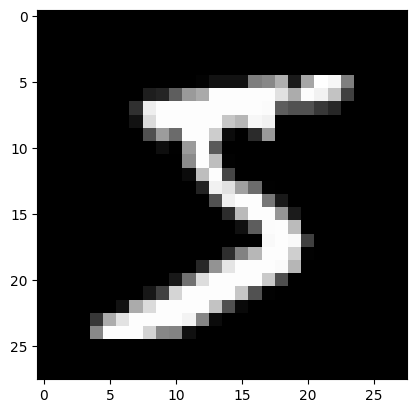

In [4]:
def plt_image(image):
    plt.imshow(image.reshape(28, 28), cmap=plt.get_cmap('gray'))

image1 = x_train[0]
label1 = y_train[0]
print(f'Image label {label1}')
plt_image(image1)

## Preprocessing

In [5]:
def normalizeImage(x_data):
    x_mean = np.mean(x_data)
    x_std = np.std(x_data)
    return (x_data - x_mean) / x_std


x_train = normalizeImage(x_train)
x_val = normalizeImage(x_val)
x_test= normalizeImage(x_test)

## Create Batch Generator

In [6]:
def create_minibatches(x, y, batch_size, shuffle= True):
    len_data = len(x)
    if shuffle:
        idx = np.random.permutation(len_data)
        x = x[idx]
        y = y[idx]
    return [(x[i:i+batch_size], y[i:i+batch_size]) for i in range(0, len_data, batch_size)]


# Pytorch


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## Prepare data

### Convert NumpyArray → torch.tensor

In [8]:
x_train_tensor = torch.tensor(x_train.copy()).to(dtype=torch.float32)
x_test_tensor = torch.tensor(x_test.copy()).to(dtype=torch.float32)
x_val_tensor = torch.tensor(x_val.copy()).to(dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.copy())
y_test_tensor = torch.tensor(y_test.copy())
y_val_tensor = torch.tensor(y_val.copy())

In [9]:
print(x_train_tensor.shape)
print(x_test_tensor.shape)
print(x_val_tensor.shape)

print(y_train_tensor.shape)
print(y_test_tensor.shape)
print(y_val_tensor.shape)

torch.Size([50000, 784])
torch.Size([10000, 784])
torch.Size([10000, 784])
torch.Size([50000, 1])
torch.Size([10000, 1])
torch.Size([10000, 1])


### Use GPU

In [10]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f"We are using {device}")

We are using cpu


## Compute accuracy

In [11]:
def accuracy(model, x, y, mb_size):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device= device)
    with torch.no_grad():
        for (xi, yi) in create_minibatches(x, y, mb_size):
            xi = xi.to(device = device, dtype = torch.float32)
            yi = yi.to(device = device, dtype = torch.long)    
            scores = model(xi)
            # dim = 1 means we are taking the index of the max value in each row
            _, preds = scores.max(dim=1)
            # preds.shape => (mb_size,) yi.shape => (mb_size, 1)
            num_correct += (preds == yi.squeeze()).sum()
            # yi.size(0) is the number of elements in the batch
            num_total += yi.size(0)
        return float(num_correct) / num_total


## Training loop

In [12]:
def train(model, optimizer, mb_size, verbose=False):
    model= model.to(device = device)
    acc = 0.0
    epoch = 0
    while acc<0.95:
        model.train()
        for (xi, yi) in create_minibatches(x_train_tensor, y_train_tensor, mb_size):
            xi = xi.to(device = device, dtype = torch.float32)
            yi = yi.to(device = device, dtype = torch.long)

            scores = model(xi)
            # cost function
            cost = F.cross_entropy(input = scores, target = yi.squeeze())
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()
        epoch += 1
        acc = accuracy(model, x_val_tensor, y_val_tensor, mb_size)
        print(f'Epoch: {epoch}, cost: {cost.item()}, accuracy: {acc}')
            



## Training with SGD

In [13]:
hidden1 = 1000
hidden2 = 1000
mb_size = 4096
lr = 1e-2


# Instantiate the model
model1 = nn.Sequential(
    nn.Linear(in_features=784, out_features=hidden1),
    nn.ReLU(),
    nn.Linear(in_features =hidden1, out_features=hidden2),
    nn.ReLU(),
    nn.Linear(in_features=hidden2, out_features=10)
)

optimizer = torch.optim.SGD(model1.parameters(), lr = lr)
train(model1, optimizer, mb_size)
acc = accuracy(model1, x_val_tensor, y_val_tensor, mb_size)
print(f'with learning rate {lr} the accuracy is {acc}')


Epoch: 1, cost: 2.228043556213379, accuracy: 0.3737
Epoch: 2, cost: 2.1458098888397217, accuracy: 0.5536
Epoch: 3, cost: 2.045558214187622, accuracy: 0.6508
Epoch: 4, cost: 1.9632009267807007, accuracy: 0.6999
Epoch: 5, cost: 1.8318195343017578, accuracy: 0.7246
Epoch: 6, cost: 1.7296510934829712, accuracy: 0.7505
Epoch: 7, cost: 1.60267174243927, accuracy: 0.7684
Epoch: 8, cost: 1.4676405191421509, accuracy: 0.7812
Epoch: 9, cost: 1.3500102758407593, accuracy: 0.7935
Epoch: 10, cost: 1.2159894704818726, accuracy: 0.8079
Epoch: 11, cost: 1.1360201835632324, accuracy: 0.8206
Epoch: 12, cost: 0.9914644956588745, accuracy: 0.8296
Epoch: 13, cost: 1.0072038173675537, accuracy: 0.8385
Epoch: 14, cost: 0.8766016960144043, accuracy: 0.8446
Epoch: 15, cost: 0.864666759967804, accuracy: 0.8505
Epoch: 16, cost: 0.7635716795921326, accuracy: 0.8551
Epoch: 17, cost: 0.7305755615234375, accuracy: 0.8595
Epoch: 18, cost: 0.7180152535438538, accuracy: 0.8638
Epoch: 19, cost: 0.660862922668457, accura

# SGD with Momentum

In [14]:
hidden1 = 1000
hidden2 = 1000
mb_size = 4096
lr = 1e-2


# Instantiate the model
model2 = nn.Sequential(
    nn.Linear(in_features=784, out_features=hidden1),
    nn.ReLU(),
    nn.Linear(in_features =hidden1, out_features=hidden2),
    nn.ReLU(),
    nn.Linear(in_features=hidden2, out_features=10)
)

optimizer = torch.optim.SGD(model2.parameters(), lr = lr, momentum=0.9)
train(model2, optimizer, mb_size)
acc = accuracy(model2, x_val_tensor, y_val_tensor, mb_size)
print(f'with learning rate {lr} the accuracy is {acc}')

Epoch: 1, cost: 1.9743847846984863, accuracy: 0.7267
Epoch: 2, cost: 1.1435048580169678, accuracy: 0.8047
Epoch: 3, cost: 0.658129870891571, accuracy: 0.8617
Epoch: 4, cost: 0.4779020845890045, accuracy: 0.8849
Epoch: 5, cost: 0.3703247904777527, accuracy: 0.8994
Epoch: 6, cost: 0.3556472957134247, accuracy: 0.9045
Epoch: 7, cost: 0.27768367528915405, accuracy: 0.9095
Epoch: 8, cost: 0.2843078076839447, accuracy: 0.9144
Epoch: 9, cost: 0.29759088158607483, accuracy: 0.9177
Epoch: 10, cost: 0.3479636609554291, accuracy: 0.9212
Epoch: 11, cost: 0.2946082651615143, accuracy: 0.9247
Epoch: 12, cost: 0.25849252939224243, accuracy: 0.9272
Epoch: 13, cost: 0.26719361543655396, accuracy: 0.9289
Epoch: 14, cost: 0.27311399579048157, accuracy: 0.9301
Epoch: 15, cost: 0.2668359577655792, accuracy: 0.9323
Epoch: 16, cost: 0.19098392128944397, accuracy: 0.9339
Epoch: 17, cost: 0.25633513927459717, accuracy: 0.9363
Epoch: 18, cost: 0.20688194036483765, accuracy: 0.9373
Epoch: 19, cost: 0.22572016716

# RMSProp

In [15]:
hidden1 = 1000
hidden2 = 1000
mb_size = 4096
lr = 1e-2


# Instantiate the model
model3 = nn.Sequential(
    nn.Linear(in_features=784, out_features=hidden1),
    nn.ReLU(),
    nn.Linear(in_features =hidden1, out_features=hidden2),
    nn.ReLU(),
    nn.Linear(in_features=hidden2, out_features=10)
)

optimizer = torch.optim.RMSprop(model3.parameters(), lr = lr, alpha=0.9)
train(model3, optimizer, mb_size)
acc = accuracy(model3, x_val_tensor, y_val_tensor, mb_size)
print(f'with learning rate {lr} the accuracy is {acc}')

Epoch: 1, cost: 1.102938175201416, accuracy: 0.7574
Epoch: 2, cost: 0.5033108592033386, accuracy: 0.8787
Epoch: 3, cost: 0.3034345209598541, accuracy: 0.9252
Epoch: 4, cost: 0.21724681556224823, accuracy: 0.9275
Epoch: 5, cost: 0.6248605847358704, accuracy: 0.8532
Epoch: 6, cost: 0.20916250348091125, accuracy: 0.9523
with learning rate 0.01 the accuracy is 0.9523


# Adam

In [ ]:
hidden1 = 1000
hidden2 = 1000
mb_size = 4096
lr = 1e-2


# Instantiate the model
model4 = nn.Sequential(
    nn.Linear(in_features=784, out_features=hidden1),
    nn.ReLU(),
    nn.Linear(in_features =hidden1, out_features=hidden2),
    nn.ReLU(),
    nn.Linear(in_features=hidden2, out_features=10)
)

optimizer = torch.optim.Adam(model4.parameters(), lr = lr, betas= (0.9, 0.999))
train(model4, optimizer, mb_size)
acc = accuracy(model4, x_val_tensor, y_val_tensor, mb_size)
print(f'with learning rate {lr} the accuracy is {acc}')

Epoch: 1, cost: 0.8015338778495789, accuracy: 0.7952
Epoch: 2, cost: 0.27738553285598755, accuracy: 0.9261
Epoch: 3, cost: 0.17302459478378296, accuracy: 0.95
with learning rate 0.01 the accuracy is 0.95
